In [91]:
from collections import OrderedDict
import torch
import torch.nn as nn
from pathlib import Path
import numpy as np
from tifffile import TiffFile
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import copy

# Implementation of UNet

In [174]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=10, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4,kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")
        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [175]:
unet = UNet()
print(unet)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Dataset

In [4]:
class LandCoverData():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [5]:
def show_image(image, display_min=50, display_max=400, ax=None):
    """Show an image.
    Args:
        image (numpy.array[uint16]): the image. If the image is 16-bit, apply bytescaling to convert to 8-bit
    """
    if image.dtype == np.uint16:
        iscale = display_max - display_min
        scale = 255 / iscale
        byte_im = (image) * scale
        byte_im = (byte_im.clip(0, 255) + 0.5).astype(np.uint8)
        image = byte_im
    # show image
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(image)
    return im

def show_mask(mask, classes_colorpalette, classes=None, add_legend=True, ax=None):
    """Show a a semantic segmentation mask.
    Args:
       mask (numpy.array[uint8]): the mask in 8-bit
       classes_colorpalette (dict[int, tuple]): dict mapping class index to an RGB color in [0, 1]
       classes (list[str], optional): list of class labels
       add_legend
    """
    show_mask = np.empty((*mask.shape, 3))
    for c, color in classes_colorpalette.items():
        show_mask[mask == c, :] = color
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis("off")
    im = ax.imshow(show_mask)
    if add_legend:
        # show legend mapping pixel colors to class names
        import matplotlib.patches as mpatches
        handles = []
        for c, color in classes_colorpalette.items():
            handles.append(mpatches.Patch(color=color, label=classes[c]))
        ax.legend(handles=handles)
    return im

In [6]:
def numpy_parse_image(image_path, mask_path):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path (bytes): path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        mask = mask[..., None]
    return image, mask

(256, 256, 4)


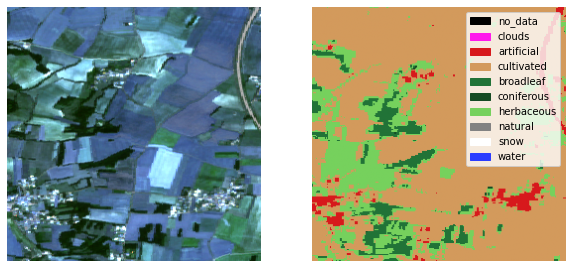

In [7]:
LCD = LandCoverData()

image_path = 'Small_dataset/train/images/1.tif'
mask_path = 'Small_dataset/train/masks/1.tif'
image, mask = numpy_parse_image(image_path, mask_path)
print(image.shape)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
show_image(image, display_min=0, display_max=2200, ax=axs[0])
classes_colorpalette = {c: color/255. for (c, color) in LCD.CLASSES_COLORPALETTE.items()}
show_mask(mask.reshape((256,256)), classes_colorpalette = classes_colorpalette, classes=LCD.CLASSES, add_legend=True, ax=axs[1])
plt.show()

In [8]:
def normalize(input_image, input_mask):
    image = np.float32(input_image)/LCD.TRAIN_PIXELS_MAX
    return image, input_mask

In [9]:
image, mask = normalize(input_image=image, input_mask=mask)

In [10]:
def load_image_train(input_image, input_mask):

    image, mask = input_image, input_mask
    if np.random.uniform(()) > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    if np.random.uniform(()) > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    if np.random.uniform(()) > 0.5:
        image = np.rot90(image)
        mask = np.rot90(mask)
    elif np.random.uniform(()) > 0.5:
        image = np.rot90(image, 3)
        mask = np.rot90(mask, 3)

    image, mask = normalize(image, mask)
    return image, mask   

In [11]:
image_path = 'Small_dataset/train/images/10.tif'
mask_path = 'Small_dataset/train/masks/10.tif'
image, mask = numpy_parse_image(image_path, mask_path)

image, mask = load_image_train(image, mask)
print(image)

[[[0.04540975 0.05817868 0.07665462 0.11130728]
  [0.04540975 0.05817868 0.07665462 0.11130728]
  [0.04426014 0.05858926 0.07107078 0.11237478]
  ...
  [0.0220069  0.02993102 0.03777303 0.07727049]
  [0.0220069  0.02993102 0.03777303 0.07727049]
  [0.02648218 0.03469371 0.04762687 0.06717031]]

 [[0.04561504 0.05817868 0.07566924 0.11237478]
  [0.04561504 0.05817868 0.07566924 0.11237478]
  [0.04167351 0.05637215 0.06680079 0.11426342]
  ...
  [0.01859911 0.02783708 0.03264083 0.09123009]
  [0.01859911 0.02783708 0.03264083 0.09123009]
  [0.02545574 0.03420102 0.0445886  0.06655444]]

 [[0.04639514 0.05969781 0.07406799 0.11249795]
  [0.04639514 0.05969781 0.07406799 0.11249795]
  [0.03941534 0.053416   0.06372146 0.11824602]
  ...
  [0.01535556 0.02664641 0.02787814 0.11101987]
  [0.01535556 0.02664641 0.02787814 0.11101987]
  [0.02586632 0.03420102 0.04553293 0.07378059]]

 ...

 [[0.0177369  0.03071112 0.02410084 0.1339711 ]
  [0.02007719 0.0324766  0.030629   0.12777139]
  [0.02007

In [12]:
class ImageSegementationDataset(Dataset):

    in_channels = 4
    out_channels = 10

    def __init__(self, images_dir, image_size=256, subset="train", seed=42):

        random.seed(seed)
        assert subset in ["all", "train", "validation"]
        images = {}
        masks = {}
        for path in os.listdir(os.path.join(images_dir, 'images')):

            image_path = os.path.join(images_dir,'images', path).replace('\\', '/')
            mask_path = os.path.join(images_dir,'masks', path).replace('\\', '/')
            # Conversion to array
            im, msk = numpy_parse_image(image_path, mask_path)
            # Rotation/inversion and normalization
            im, msk = load_image_train(im, msk)
            images[image_path] = im
            masks[image_path] = msk

        self.images = images
        self.masks = masks

        self.all_images = sorted(images)

        if not subset == 'all':
            valset_size = int(0.1*len(images))
            validation_images = random.sample(self.all_images, k=valset_size)
            if subset == 'validation':
                self.all_images = validation_images
            else:
                self.all_images = sorted(list(set(self.all_images).difference(validation_images)))

        self.index2impath = {i : self.all_images[i] for i in range(0, len(self.all_images))}
        self.concat_data = [(images[k], masks[k]) for k in self.all_images]
        # print(self.all_images)

    def __len__(self):
        return len(self.concat_data)

    def __getitem__(self, idx):

        path = self.index2impath[idx]
        image, mask = self.images[path], self.masks[path]

        # dimensions [C, H, W]
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image)
        mask_tensor = torch.from_numpy(mask)

        return image_tensor, mask_tensor

In [13]:
def build_datasets(images_dir):

    train = ImageSegementationDataset(images_dir)

    valid = ImageSegementationDataset(images_dir, subset='validation')

    return train, valid

In [14]:
images_dir = 'Small_dataset/train'
train, valid = build_datasets(images_dir)
print(train)

In [206]:
batch_size = 32
epochs= 10
lr= 0.001

def build_dataloaders(images_dir):

    dataset_train, dataset_valid = build_datasets(images_dir)

    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    loader_valid = DataLoader(dataset_valid, batch_size=batch_size)

    dataset_sizes = {'train': len(dataset_train), 'valid': len(dataset_valid)}

    return loader_train, loader_valid, dataset_sizes

In [207]:
loader_train, loader_valid, dataset_sizes = build_dataloaders(images_dir)

In [17]:
images_train, labels_train = next(iter(loader_train))
images_val, labels_val = next(iter(loader_valid))

In [18]:
print(images_train.size())

torch.Size([18, 4, 256, 256])


In [19]:
print(images_val.size())

torch.Size([2, 4, 256, 256])


In [20]:
print(labels_train.size())

torch.Size([18, 1, 256, 256])


In [21]:
print(labels_val.size())

torch.Size([2, 1, 256, 256])


In [208]:
print(dataset_sizes)

{'train': 18, 'valid': 2}


In [22]:
# Adam optimizer
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

In [23]:
# Class_weight
weights = np.zeros((LCD.N_CLASSES,))
num_ign_classes = len(LCD.IGNORED_CLASSES_IDX)
weights[num_ign_classes:] = (1 / LCD.TRAIN_CLASS_COUNTS[2:])* LCD.TRAIN_CLASS_COUNTS[2:].sum() / (LCD.N_CLASSES-2)
weights[LCD.IGNORED_CLASSES_IDX] = 0.

class_weights = torch.FloatTensor(weights)

# Criterion
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [27]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [28]:
SMOOTH = 1e-6

def mIOU(label, pred, num_classes=10):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    print(pred.size())
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [215]:
def training(model, train_loader, valid_loader, data_sizes, epochs, optimizer, scheduler, title):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    since = time.time()

    training_loss = []
    validation_loss = []
    num_workers = 1

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loaders = {"train": train_loader, "valid": valid_loader}
    step = 0

    # criterion = DiceLoss()
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for image, mask in loaders[phase]:
                image = image.to(device)
                mask = mask.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):

                    output = model(image)
                    # print(output)
                    _, preds = torch.max(output, 1)

                    loss = criterion(output, torch.tensor(mask, dtype=torch.long, device=device).squeeze())
                    # loss = criterion(output, mask)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*num_workers
                # running_corrects += torch.sum(iou_pytorch(output, mask))
                running_corrects += torch.sum(preds == mask.data)

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss/data_sizes[phase]
            epoch_acc = running_corrects.double()/(data_sizes[phase]*preds.size(1)*preds.size(2))
            if phase == 'train':
                training_loss.append(epoch_loss)
            else:
                validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

            
    # Plotting the validation loss and training loss
    print('validation loss: ' + str(validation_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model)

    # plot the training and validation loss
    plt.figure()
    plt.plot(training_loss, 'b', label='Training Loss')
    plt.plot(validation_loss, 'r', label='Validation Loss')
    plt.title(title)
    plt.legend()
    plt.show() #Change title for every model

    return model

In [216]:
def train_model(data_dir, model, epochs):

    loader_train, loader_valid, data_sizes = build_dataloaders(data_dir)

    class_weights = torch.FloatTensor(weights)

    # Optimizing all parameters
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    # Training the model
    title = 'Variations of the training and validation loss'
    model_ft = training(model, loader_train, loader_valid, data_sizes, epochs, optimizer_ft, exp_lr_scheduler, title)

    return model_ft

Epoch 1/10
----------
train Loss: 0.1275 Acc: 2.2245
valid Loss: 1.1376 Acc: 0.8972
Epoch 2/10
----------
train Loss: 0.1274 Acc: 2.2274
valid Loss: 1.1372 Acc: 0.8972
Epoch 3/10
----------
train Loss: 0.1274 Acc: 2.2337
valid Loss: 1.1370 Acc: 0.8972
Epoch 4/10
----------
train Loss: 0.1274 Acc: 2.2431
valid Loss: 1.1369 Acc: 0.8972
Epoch 5/10
----------
train Loss: 0.1272 Acc: 2.2560
valid Loss: 1.1368 Acc: 0.8972
Epoch 6/10
----------
train Loss: 0.1272 Acc: 2.2737
valid Loss: 1.1367 Acc: 0.8972
Epoch 7/10
----------
train Loss: 0.1270 Acc: 2.2949
valid Loss: 1.1363 Acc: 0.8972
Epoch 8/10
----------
train Loss: 0.1270 Acc: 2.3223
valid Loss: 1.1358 Acc: 0.8972
Epoch 9/10
----------
train Loss: 0.1270 Acc: 2.3253
valid Loss: 1.1355 Acc: 0.8972
Epoch 10/10
----------
train Loss: 0.1271 Acc: 2.3285
valid Loss: 1.1352 Acc: 0.8971
validation loss: [1.1376150846481323, 1.1371650695800781, 1.137008547782898, 1.136926293373108, 1.1368342638015747, 1.1366820335388184, 1.1362725496292114, 1.1

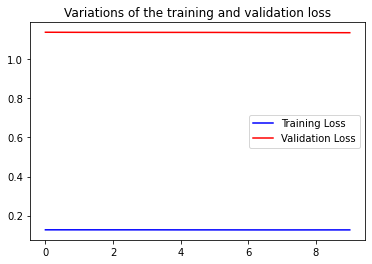

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [218]:
train_model('Small_dataset/train', unet, epochs=10)